In [1]:
#@title Dataset Definition

"""Smart Buildings Dataset implementation, including loading and downloading."""


import json
import pickle
import shutil
import numpy as np
import requests





class SmartBuildingsDataset:
 """Smart Buildings Dataset implementation, including loading and downloading."""


 def __init__(self, download=True):
   self.partitions = {
       "sb1": [
           "2022_a",
           "2022_b",
           "2023_a",
           "2023_b",
           "2024_a",
       ],
   }
   if download:
     self.download()


 def download(self):
   """Downloads the Smart Buildings Dataset from Google Cloud Storage."""
   print("Downloading data...")


   def download_file(url):
     local_filename = url.split("/")[-1]
     with requests.get(url, stream=True) as r:
       r.raise_for_status()
       with open(local_filename, "wb") as f:
         for chunk in r.iter_content(chunk_size=8192):
           f.write(chunk)
     return local_filename


   url = "https://storage.googleapis.com/gresearch/smart_buildings_dataset/tabular_data/sb1.zip"
   download_file(url)
   shutil.unpack_archive("sb1.zip", "sb1/")


 def get_floorplan(self, building):
   """Gets the floorplan and device layout map for a specific building.


   Args:
     building: The name of the building.


   Returns:
     A tuple containing the floorplan and device layout map.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   floorplan = np.load(f"./{building}/tabular/floorplan.npy")

   def gdrive_to_direct_url(share_url):
        file_id = share_url.split('/d/')[1].split('/')[0]
        return f"https://drive.google.com/uc?export=download&id={file_id}"
   share_url = "https://drive.google.com/file/d/19W4exC1IfIpx6x_agZy3HO1ARXdxKnic/view?usp=sharing"
   direct_url = gdrive_to_direct_url(share_url)
   response = requests.get(direct_url)
   device_layout_map = response.json()

   return floorplan, device_layout_map


 def get_building_data(self, building, partition):
   """Gets the data for a specific building and partition.


   Args:
     building: The name of the building.
     partition: The name of the partition.


   Returns:
     A tuple containing the data and metadata.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   if partition not in self.partitions[building]:
     raise ValueError("invalid partition")
   path = f"./{building}/tabular/{building}/{partition}/"


   data = np.load(path + "data.npy.npz")
   metadata = pickle.load(open(path + "metadata.pickle", "rb"))


   if "device_infos" not in metadata.keys():
     metadata["device_infos"] = pickle.load(
         open(f"./{building}/tabular/device_info_dicts.pickle", "rb")
     )
   if "zone_infos" not in metadata.keys():
     metadata["zone_infos"] = pickle.load(
         open(f"./{building}/tabular/zone_info_dicts.pickle", "rb")
     )
   return data, metadata


In [2]:
#@title Data download and splitting

ds = SmartBuildingsDataset()

# training data: Jan-June 2022
data, metadata = ds.get_building_data("sb1","2022_a")
floorplan, device_layout_map = ds.get_floorplan("sb1")

# validation data: July-December 2022
data_val, metadata_val = ds.get_building_data("sb1","2022_b")
floorplan_val, device_layout_map_val = ds.get_floorplan("sb1")

# lets split validation data into things to predict, and exogenous variables
indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

initial_condition = temp_data[0]

In [3]:
# Train data:
data['observation_value_matrix']
metadata["observation_ids"]
metadata["observation_timestamps"]

data['action_value_matrix']
metadata["action_ids"]

floorplan
device_layout_map
metadata["device_infos"]

# Validation data:
data_val['action_value_matrix']
metadata_val["action_ids"]
metadata_val["observation_timestamps"]
floorplan
device_layout_map

exogenous_observation_data
exogenous_observation_data_ids
initial_condition

# Predict:
temp_data
temp_data_ids







{'2760348383893915@zone_air_temperature_sensor': 0,
 '2562701969438717@zone_air_temperature_sensor': 1,
 '2806035809406684@zone_air_temperature_sensor': 2,
 '2790439929052995@zone_air_temperature_sensor': 3,
 '2628534928204590@zone_air_temperature_sensor': 4,
 '2535333053617205@zone_air_temperature_sensor': 5,
 '2619255661594253@zone_air_temperature_sensor': 6,
 '2618781414146613@zone_air_temperature_sensor': 7,
 '2613654138967436@zone_air_temperature_sensor': 8,
 '2762982574975969@zone_air_temperature_sensor': 9,
 '2578499186529204@zone_air_temperature_sensor': 10,
 '2693289483686059@zone_air_temperature_sensor': 11,
 '2549483694528743@zone_air_temperature_sensor': 12,
 '2614466029028994@zone_air_temperature_sensor': 13,
 '2760979770441910@zone_air_temperature_sensor': 14,
 '2732460999450017@zone_air_temperature_sensor': 15,
 '2549513081490212@zone_air_temperature_sensor': 16,
 '2737293899563066@zone_air_temperature_sensor': 17,
 '2710040674126014@zone_air_temperature_sensor': 18,
 '2

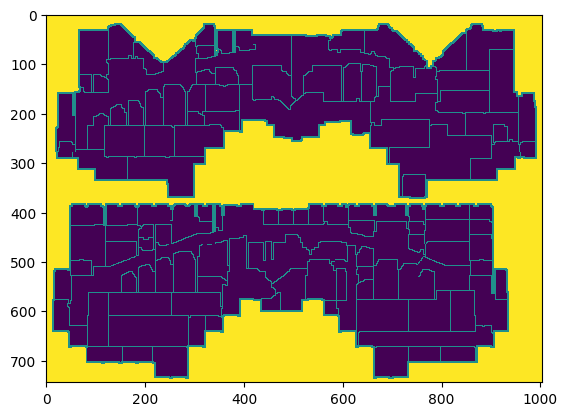

In [4]:
from matplotlib import pyplot as plt
plt.imshow(floorplan, interpolation='nearest')
plt.show()

In [5]:
metadata["device_infos"][0]


{'device_id': '202194278473007104',
 'namespace': 'PHRED',
 'code': 'SB1:AHU:AC-2',
 'zone_id': '',
 'device_type': 6,
 'observable_fields': {'building_air_static_pressure_sensor': 1,
  'outside_air_flowrate_sensor': 1,
  'supply_fan_speed_percentage_command': 1,
  'supply_air_temperature_sensor': 1,
  'supply_fan_speed_frequency_sensor': 1,
  'supply_air_static_pressure_setpoint': 1,
  'return_air_temperature_sensor': 1,
  'mixed_air_temperature_setpoint': 1,
  'exhaust_fan_speed_percentage_command': 1,
  'exhaust_fan_speed_frequency_sensor': 1,
  'outside_air_damper_percentage_command': 1,
  'mixed_air_temperature_sensor': 1,
  'exhaust_air_damper_percentage_command': 1,
  'cooling_percentage_command': 1,
  'outside_air_flowrate_setpoint': 1,
  'supply_air_temperature_setpoint': 1,
  'building_air_static_pressure_setpoint': 1,
  'supply_air_static_pressure_sensor': 1},
 'action_fields': {'exhaust_air_damper_percentage_command': 1,
  'supply_air_temperature_setpoint': 1,
  'supply_fan

In [ ]:
metadata["zone_infos"][0]


{'zone_id': 'rooms/1002000133978',
 'building_id': 'buildings/3616672508',
 'zone_description': 'SB1-2-C2054',
 'area': 0.0,
 'zone_type': 1,
 'floor': 2,
 'devices': ['2618581107144046', '2696593986887004']}

In [6]:
pip install git+https://github.com/EURAC-EEBgroup/pybuildingcluster.git

  Cloning https://github.com/EURAC-EEBgroup/pybuildingcluster.git to /tmp/pip-req-build-rgy108p_
  Running command git clone --filter=blob:none --quiet https://github.com/EURAC-EEBgroup/pybuildingcluster.git /tmp/pip-req-build-rgy108p_
  Resolved https://github.com/EURAC-EEBgroup/pybuildingcluster.git to commit 578d8bfc435d50d4b9aafac24ae62450105aa3d9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 49.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 73.0 MB/s eta 0:00:00
   ━━━━

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.308616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207291
[LightGBM] [Info] Number of data points in the train set: 51852, number of used features: 1066
[LightGBM] [Info] Start training from score 48.778735
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 10.9934	training's l2: 120.856
[20]	training's rmse: 3.84458	training's l2: 14.7808
[30]	training's rmse: 1.36174	training's l2: 1.85433
[40]	training's rmse: 0.518279	training's l2: 0.268613
[50]	training's rmse: 0.260369	training's l2: 0.0677919
[60]	training's rmse: 0.196224	training's l2: 0.0385037
[70]	training's rmse: 0.177088	training's l2: 0.0313602
[80]	training's rmse: 0.166682	training's l2: 0.0277827
[90]	training's rmse: 0.158947	training's l2: 0.0252641
[100]	training's rmse: 0.15314	tra

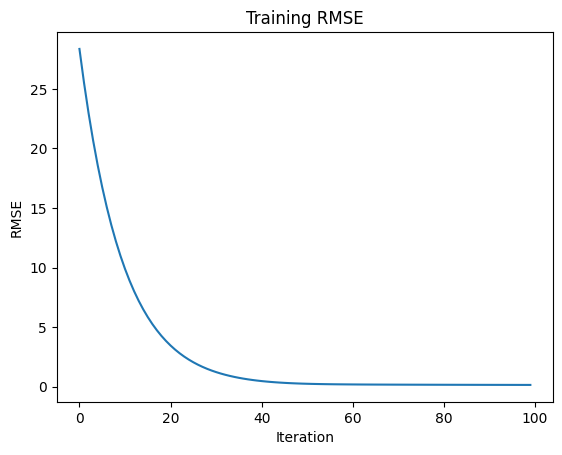

'models = builder.build_models(\n    data=df_train,\n    clusters=df_train,\n    target_column=\'target_temp\',\n    feature_columns=feature_names,\n    models_to_train=[\'lightgbm\'],  # 你也可以加 \'random_forest\',\'xgboost\' 等\n    hyperparameter_tuning="none",\n    save_models=False\n)\nmodel = models[0][\'best_model\']'

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from pybuildingcluster import RegressionModelBuilder

# —— 1. 从训练集提取外生变量和温度目标（假设data和metadata已准备好）

# 训练集目标变量索引（所有温度传感器）
indexes_train_target = [v for k, v in metadata['observation_ids'].items() if "zone_air_temperature_sensor" in k]
train_target_all = data['observation_value_matrix'][:, indexes_train_target]

# 训练集外生变量索引（非温度传感器）
indexes_train_exogenous = [v for k, v in metadata['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
train_exogenous = data['observation_value_matrix'][:, indexes_train_exogenous]

# —— 2. 选择一个温度传感器作为预测目标（这里以第0个为例）——————————————————————————————————————————————————————————
target_sensor_index = 0
y_train = train_target_all[:, target_sensor_index]
X_train = train_exogenous

# —— 3. 构造训练 DataFrame
feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]
df_train = pd.DataFrame(X_train, columns=feature_names)
df_train['target_temp'] = y_train
df_train['cluster'] = 0  # 添加cluster列，必需

# —— 4. 初始化模型构建器，训练模型
builder = RegressionModelBuilder(random_state=42, problem_type="regression")




# 实现训练过程可视化，绕开 build_models()，直接用 LightGBM（或其他模型）官方API训练

from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import matplotlib.pyplot as plt

X_train_np = df_train[feature_names].values
y_train_np = df_train['target_temp'].values

model = LGBMRegressor(n_estimators=100, random_state=42)

model.fit(
    X_train_np, y_train_np,
    eval_set=[(X_train_np, y_train_np)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=10), log_evaluation(period=10)]
)

evals_result = model.evals_result_

train_rmse = evals_result['training']['rmse']

plt.plot(train_rmse)
plt.title("Training RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.show()




'''models = builder.build_models(
    data=df_train,
    clusters=df_train,
    target_column='target_temp',
    feature_columns=feature_names,
    models_to_train=['lightgbm'],
    hyperparameter_tuning="none",
    save_models=False
)
model = models[0]['best_model']'''



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor

# —— 1. 提取训练数据
indexes_train_target = [v for k, v in metadata['observation_ids'].items() if "zone_air_temperature_sensor" in k]
train_target_all = data['observation_value_matrix'][:, indexes_train_target]

indexes_train_exogenous = [v for k, v in metadata['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
train_exogenous = data['observation_value_matrix'][:, indexes_train_exogenous]

# —— 2. 提取验证数据
indexes_val_target = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
val_target_all = data_val['observation_value_matrix'][:, indexes_val_target]

indexes_val_exogenous = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
val_exogenous = data_val['observation_value_matrix'][:, indexes_val_exogenous]

# —— 3. 训练每个传感器模型并评估
feature_names = [f'feature_{i}' for i in range(train_exogenous.shape[1])]
results = []

for i, sensor_index in enumerate(indexes_train_target):
    print(f"\n=== 训练第 {i+1}/{len(indexes_train_target)} 个温度传感器 ===")

    y_train = train_target_all[:, i]
    X_train = train_exogenous

    y_val = val_target_all[:, i]
    X_val = val_exogenous

    # 训练 LightGBM 模型
    model = LGBMRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # 预测验证集
    y_pred = model.predict(X_val)

    # 评估指标
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

    results.append({
        "sensor_index": sensor_index,
        "mae": mae,
        "rmse": rmse,
        "r2": r2,
        "y_true": y_val,
        "y_pred": y_pred
    })

    # 可视化前3个传感器的结果
    if i < 3:
        plt.figure(figsize=(12, 4))
        plt.plot(y_val, label="True")
        plt.plot(y_pred, label="Predicted", linestyle='--')
        plt.title(f"Sensor {sensor_index} - Predicted vs True")
        plt.xlabel("Time Step")
        plt.ylabel("Temperature (℉)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# —— 4. 输出整体平均表现
avg_mae = np.mean([r["mae"] for r in results])
avg_rmse = np.mean([r["rmse"] for r in results])
avg_r2 = np.mean([r["r2"] for r in results])

print("\n=== 所有传感器平均表现 ===")
print(f"平均 MAE: {avg_mae:.2f}")
print(f"平均 RMSE: {avg_rmse:.2f}")
print(f"平均 R²: {avg_r2:.4f}")


import csv

# 汇总成列表字典，并使用重新编号的序号（从1到123）
summary = []
for idx, r in enumerate(results, start=1):  # 用 enumerate 自动编号
    summary.append({
        "sensor_id": idx,  # 新编号，从 1 开始
        "mae": r["mae"],
        "rmse": r["rmse"],
        "r2": r["r2"]
    })

# 转为DataFrame保存csv
df_summary = pd.DataFrame(summary)
df_summary.to_csv("sensor_performance_summary.csv", index=False)

print("结果已保存到 sensor_performance_summary.csv")

